In [89]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [90]:
DATA_PATH: str = "data/aloes/aloes"

In [91]:
mask = np.array(
    [
    [64, 128, 1], 
    [32, 0, 2], 
    [16, 8, 4]
    ]
    ).astype(np.float64)

In [92]:
mask_5 = np.array(
        [
            [1, 2, 4, 8, 16],
            [32, 64, 128, 256, 512],
            [1024, 2048, 0, 8192, 16384],
            [32768, 65536, 131072, 262144, 524288],
            [1048576, 2097152, 4194304, 8388608, 16777216]
        ]
    ).astype(np.uint32)

In [93]:
def count_ones(n):
    count = 0
    while n:
        count += n & 1
        n >>= 1
    return count

LUT = np.array([count_ones(i) for i in range(256)])

In [94]:
def local_binary_patterns(
        image_left: np.ndarray,
        image_right: np.ndarray,
        mask: np.ndarray,	
        search_window_size: int = 3,
) -> np.ndarray:
    n = mask.shape[0]//2

    h = search_window_size//2
    median_left = cv2.medianBlur(image_left, mask.shape[0]).astype(np.uint32)
    median_right = cv2.medianBlur(image_right, mask.shape[0]).astype(np.uint32)

    binarized_left = np.zeros_like(image_left)
    binarized_right = np.zeros_like(image_right)

    result = np.zeros_like(image_left)
   
    for i in range(n, image_left.shape[0] - n):
        for j in range(n, image_left.shape[1] - n):
            binarized_left[i,j] = np.sum((image_left[i - n : i + n + 1, j - n : j + n + 1] > median_left[i, j]).astype(np.uint32) * mask)
            binarized_right[i,j] = np.sum((image_right[i - n : i + n + 1, j - n : j + n + 1] > median_right[i, j]).astype(np.uint32) * mask)

    for i in range(n, image_left.shape[0] - n):
        for j in range(n, image_left.shape[1] - n):
            min_distance = np.inf
            for k in range(-h, h + 1):
                for l in range(-h, h + 1):
                        if i + k >= 0 and j + l >= 0 and i + k < image_left.shape[0] and j + l < image_left.shape[1]:
                                distance = LUT[np.sum(np.bitwise_xor(binarized_left[i, j], binarized_right[i + k, j + l])).astype(np.uint32)]
                                if distance < min_distance:
                                        min_distance = distance
            result[i, j] = min_distance
    return result


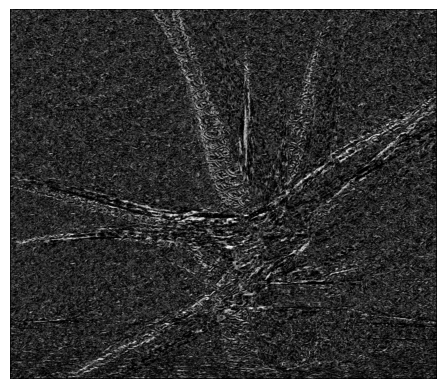

In [95]:
depth = local_binary_patterns(
    cv2.imread(os.path.join(DATA_PATH, "aloeL.jpg"), cv2.IMREAD_GRAYSCALE),
    cv2.imread(os.path.join(DATA_PATH, "aloeR.jpg"), cv2.IMREAD_GRAYSCALE),
    mask_5,
    5,
)

plt.imshow(depth, cmap="gray")  
plt.axis("off")
plt.show()



In [ ]:
# make 8 by 8 subplot
fig, axs = plt.subplots(8, 8, figsize=(20, 20))
for i in range(8):
    for j in range(8):
        axs[i, j].imshow(depth[i*50:(i+1)*50, j*50:(j+1)*50], cmap="gray")
        axs[i, j].axis("off")
        axs[i, j].set_title(f"({i*50}, {j*50})")